# Timeseries visualizations of snow depth and others parameters at Oukaimeden station (lat:31.20, lon:-7.86, alt:3230m ) over the period 2015-2021

## 1. Import python models

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import os 
import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import datetime as dt
import calendar as cld
import matplotlib.pyplot as plt
import xarray as xr
from os import listdir
from os.path import isfile, join
import cartopy.crs as ccrs
import cartopy 
import proplot as plot  # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import sys
import pymannkendall as mk
import calendar
import time
import matplotlib.image as mpimg
import plotly.express as px   
import datetime

## 2. Data wrangling and auxiliary functions

In [2]:
# The data files are xlsx files,  
path_snow_depth_data = '/home/hchaabani//snow_data/in_situ_sd/Data_LMI_Montagne_2021'
ouk_SD = pd.read_excel(path_snow_depth_data+"/Ouka2_hauteur_neige_2009-2021_N0_Unification.xlsx") 
ouk_P = pd.read_excel(path_snow_depth_data+"/Geonor_J_Ouka_Neltner_synthèse_FG+VS_v2___Baba.xlsx")

In [3]:
ouk_SD

,year,month,day,SD
0,Year,Month,Day,Moyenne de Oukaimeden_M_ISav_(m)
1,2009,NaN,NaN,0.058765
2,2010,NaN,NaN,0.407904
3,2011,NaN,NaN,0.511897
4,2012,NaN,NaN,1.415068
...,...,...,...,...
2571,NaN,NaN,11,0.005812
2572,NaN,NaN,12,0.006729
2573,NaN,NaN,13,0.008167
2574,NaN,NaN,14,0.008308


In [4]:
ouk_P

,Annee_hydro,Date,P_J_Ouka,N_J_Ouka,P_J_Ouka_recons,N_J_Ouka_recons,Total,Total>1mm,Commentaires
0,2010,2009-11-05,0,0,NaN,0,0,0,NaN
1,2010,2009-11-06,0,0,NaN,0,0,0,NaN
2,2010,2009-11-07,0,0,NaN,0,0,0,NaN
3,2010,2009-11-08,0,0,NaN,0,0,0,NaN
4,2010,2009-11-09,0,0,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...
3993,2021,2020-10-11,0.1,0,0.1,NaN,0.1,0,NaN
3994,2021,2020-10-12,0,0,0,NaN,0,0,NaN
3995,2021,2020-10-13,0,0,0,NaN,0,0,Maintenance Geonor
3996,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
ouk_P = ouk_P[['Annee_hydro', 'Date', 'P_J_Ouka', 'N_J_Ouka_recons', 'Total>1mm']]

In [6]:
ouk_P

,Annee_hydro,Date,P_J_Ouka,N_J_Ouka_recons,Total>1mm
0,2010,2009-11-05,0,0,0
1,2010,2009-11-06,0,0,0
2,2010,2009-11-07,0,0,0
3,2010,2009-11-08,0,0,0
4,2010,2009-11-09,0,0,0
...,...,...,...,...,...
3993,2021,2020-10-11,0.1,NaN,0
3994,2021,2020-10-12,0,NaN,0
3995,2021,2020-10-13,0,NaN,0
3996,NaN,NaT,NaN,NaN,NaN


In [7]:
year = 2015
for i in range(8,2575):
    if ouk_SD['year'][i] is np.nan:
        ouk_SD['year'][i]=year
    else:
        year=ouk_SD['year'][i]

In [8]:
mon = 1
for i in range(8,2575):
    if ouk_SD['month'][i] is np.nan:
        ouk_SD['month'][i]=mon
    else:
        mon=ouk_SD['month'][i]

In [9]:
for i in range(8,2575):
    if ouk_SD['day'][i] is np.nan:
        ouk_SD.drop([i], axis=0, inplace=True)

In [10]:
ouk_SD.drop([0,1,2,3,4,5,6, 2575], axis=0, inplace=True)

In [11]:
ouk_SD.drop([7], axis=0, inplace=True)

In [12]:
ouk_SD

,year,month,day,SD
9,2015,1,1,1.00725
10,2015,1,2,1.004229
11,2015,1,3,1.001854
12,2015,1,4,0.998667
13,2015,1,5,0.998042
...,...,...,...,...
2570,2021,10,10,0.006063
2571,2021,10,11,0.005812
2572,2021,10,12,0.006729
2573,2021,10,13,0.008167


In [13]:
date = pd.to_datetime(ouk_SD[['year', 'month', 'day']])

In [14]:
ouk_SD['date']=date

In [15]:
ouk_SD

,year,month,day,SD,date
9,2015,1,1,1.00725,2015-01-01
10,2015,1,2,1.004229,2015-01-02
11,2015,1,3,1.001854,2015-01-03
12,2015,1,4,0.998667,2015-01-04
13,2015,1,5,0.998042,2015-01-05
...,...,...,...,...,...
2570,2021,10,10,0.006063,2021-10-10
2571,2021,10,11,0.005812,2021-10-11
2572,2021,10,12,0.006729,2021-10-12
2573,2021,10,13,0.008167,2021-10-13


In [16]:
ouk_SD.set_index('date', inplace=True)

In [17]:
ouk_SD

,year,month,day,SD
date,,,,
2015-01-01,2015,1,1,1.00725
2015-01-02,2015,1,2,1.004229
2015-01-03,2015,1,3,1.001854
2015-01-04,2015,1,4,0.998667
2015-01-05,2015,1,5,0.998042
...,...,...,...,...
2021-10-10,2021,10,10,0.006063
2021-10-11,2021,10,11,0.005812
2021-10-12,2021,10,12,0.006729


In [18]:
ouk_P

,Annee_hydro,Date,P_J_Ouka,N_J_Ouka_recons,Total>1mm
0,2010,2009-11-05,0,0,0
1,2010,2009-11-06,0,0,0
2,2010,2009-11-07,0,0,0
3,2010,2009-11-08,0,0,0
4,2010,2009-11-09,0,0,0
...,...,...,...,...,...
3993,2021,2020-10-11,0.1,NaN,0
3994,2021,2020-10-12,0,NaN,0
3995,2021,2020-10-13,0,NaN,0
3996,NaN,NaT,NaN,NaN,NaN


In [19]:
ouk_P = ouk_P.drop(labels=[3996, 3997], axis=0)

In [20]:
ouk_P['year'] = np.nan

In [21]:
ouk_P

,Annee_hydro,Date,P_J_Ouka,N_J_Ouka_recons,Total>1mm,year
0,2010,2009-11-05,0,0,0,NaN
1,2010,2009-11-06,0,0,0,NaN
2,2010,2009-11-07,0,0,0,NaN
3,2010,2009-11-08,0,0,0,NaN
4,2010,2009-11-09,0,0,0,NaN
...,...,...,...,...,...,...
3991,2021,2020-10-09,0,NaN,0,NaN
3992,2021,2020-10-10,0.2,NaN,0,NaN
3993,2021,2020-10-11,0.1,NaN,0,NaN
3994,2021,2020-10-12,0,NaN,0,NaN


In [22]:
for i in range(3996):
    ouk_P['year'][i] = str(ouk_P['Date'][i])[0:4]

/tmp/ipykernel_71172/215989812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ouk_P['year'][i] = str(ouk_P['Date'][i])[0:4]


In [23]:
ouk_P.set_index('Date', inplace=True)

In [24]:
ouk_P = ouk_P[['Annee_hydro','year','P_J_Ouka', 'N_J_Ouka_recons', 'Total>1mm']]

In [25]:
ouk_P

,Annee_hydro,year,P_J_Ouka,N_J_Ouka_recons,Total>1mm
Date,,,,,
2009-11-05,2010,2009,0,0,0
2009-11-06,2010,2009,0,0,0
2009-11-07,2010,2009,0,0,0
2009-11-08,2010,2009,0,0,0
2009-11-09,2010,2009,0,0,0
...,...,...,...,...,...
2020-10-09,2021,2020,0,NaN,0
2020-10-10,2021,2020,0.2,NaN,0
2020-10-11,2021,2020,0.1,NaN,0


In [26]:
ouk_SD

,year,month,day,SD
date,,,,
2015-01-01,2015,1,1,1.00725
2015-01-02,2015,1,2,1.004229
2015-01-03,2015,1,3,1.001854
2015-01-04,2015,1,4,0.998667
2015-01-05,2015,1,5,0.998042
...,...,...,...,...
2021-10-10,2021,10,10,0.006063
2021-10-11,2021,10,11,0.005812
2021-10-12,2021,10,12,0.006729


In [27]:
aux1 = ouk_SD.loc['2017-06-01':'2017-09-30']
aux2 = ouk_SD.loc['2018-06-01':'2018-09-30']
aux3 = ouk_SD.loc['2019-06-01':'2019-09-30']
aux4 = ouk_SD.loc['2020-06-01':'2020-09-30']
aux5 = ouk_SD.loc['2021-06-01':'2021-09-30']

In [28]:
wrong_data = aux1.append([aux2, aux3, aux4, aux5])

/tmp/ipykernel_71172/3068756079.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wrong_data = aux1.append([aux2, aux3, aux4, aux5])


In [29]:
wrong_data['SD'].mean()

0.021430366124859677

In [30]:
wrong_data['SD'].median()

0.01641666657330155

In [31]:
med = wrong_data['SD'].median()

In [32]:
ouk_SD['SD'] = ouk_SD['SD'] - med

In [33]:
ouk_SD['SD'].loc['2015-06-01':'2015-09-30'] = 0
ouk_SD['SD'].loc['2016-06-01':'2016-09-30'] = 0
ouk_SD['SD'].loc['2017-06-01':'2017-09-30'] = 0
ouk_SD['SD'].loc['2018-06-01':'2018-09-30'] = 0
ouk_SD['SD'].loc['2019-06-01':'2019-09-30'] = 0
ouk_SD['SD'].loc['2020-06-01':'2020-09-30'] = 0
ouk_SD['SD'].loc['2021-06-01':'2021-09-30'] = 0

In [34]:
ouk_SD['SD'] = ouk_SD['SD'].clip(lower=0)

### An auxiliary function 

In [35]:
# This auxiliary function will help us in the formatting of the figures
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

## 2. Timeseries visualizations

### Snow depth time series 

In [43]:
ouk_P.loc[ouk_P['N_J_Ouka_recons'] == 'Nodata', 'N_J_Ouka_recons'] = np.nan

In [44]:
ouk_P.loc[ouk_P['P_J_Ouka'] == 'Nodata', 'P_J_Ouka'] = np.nan

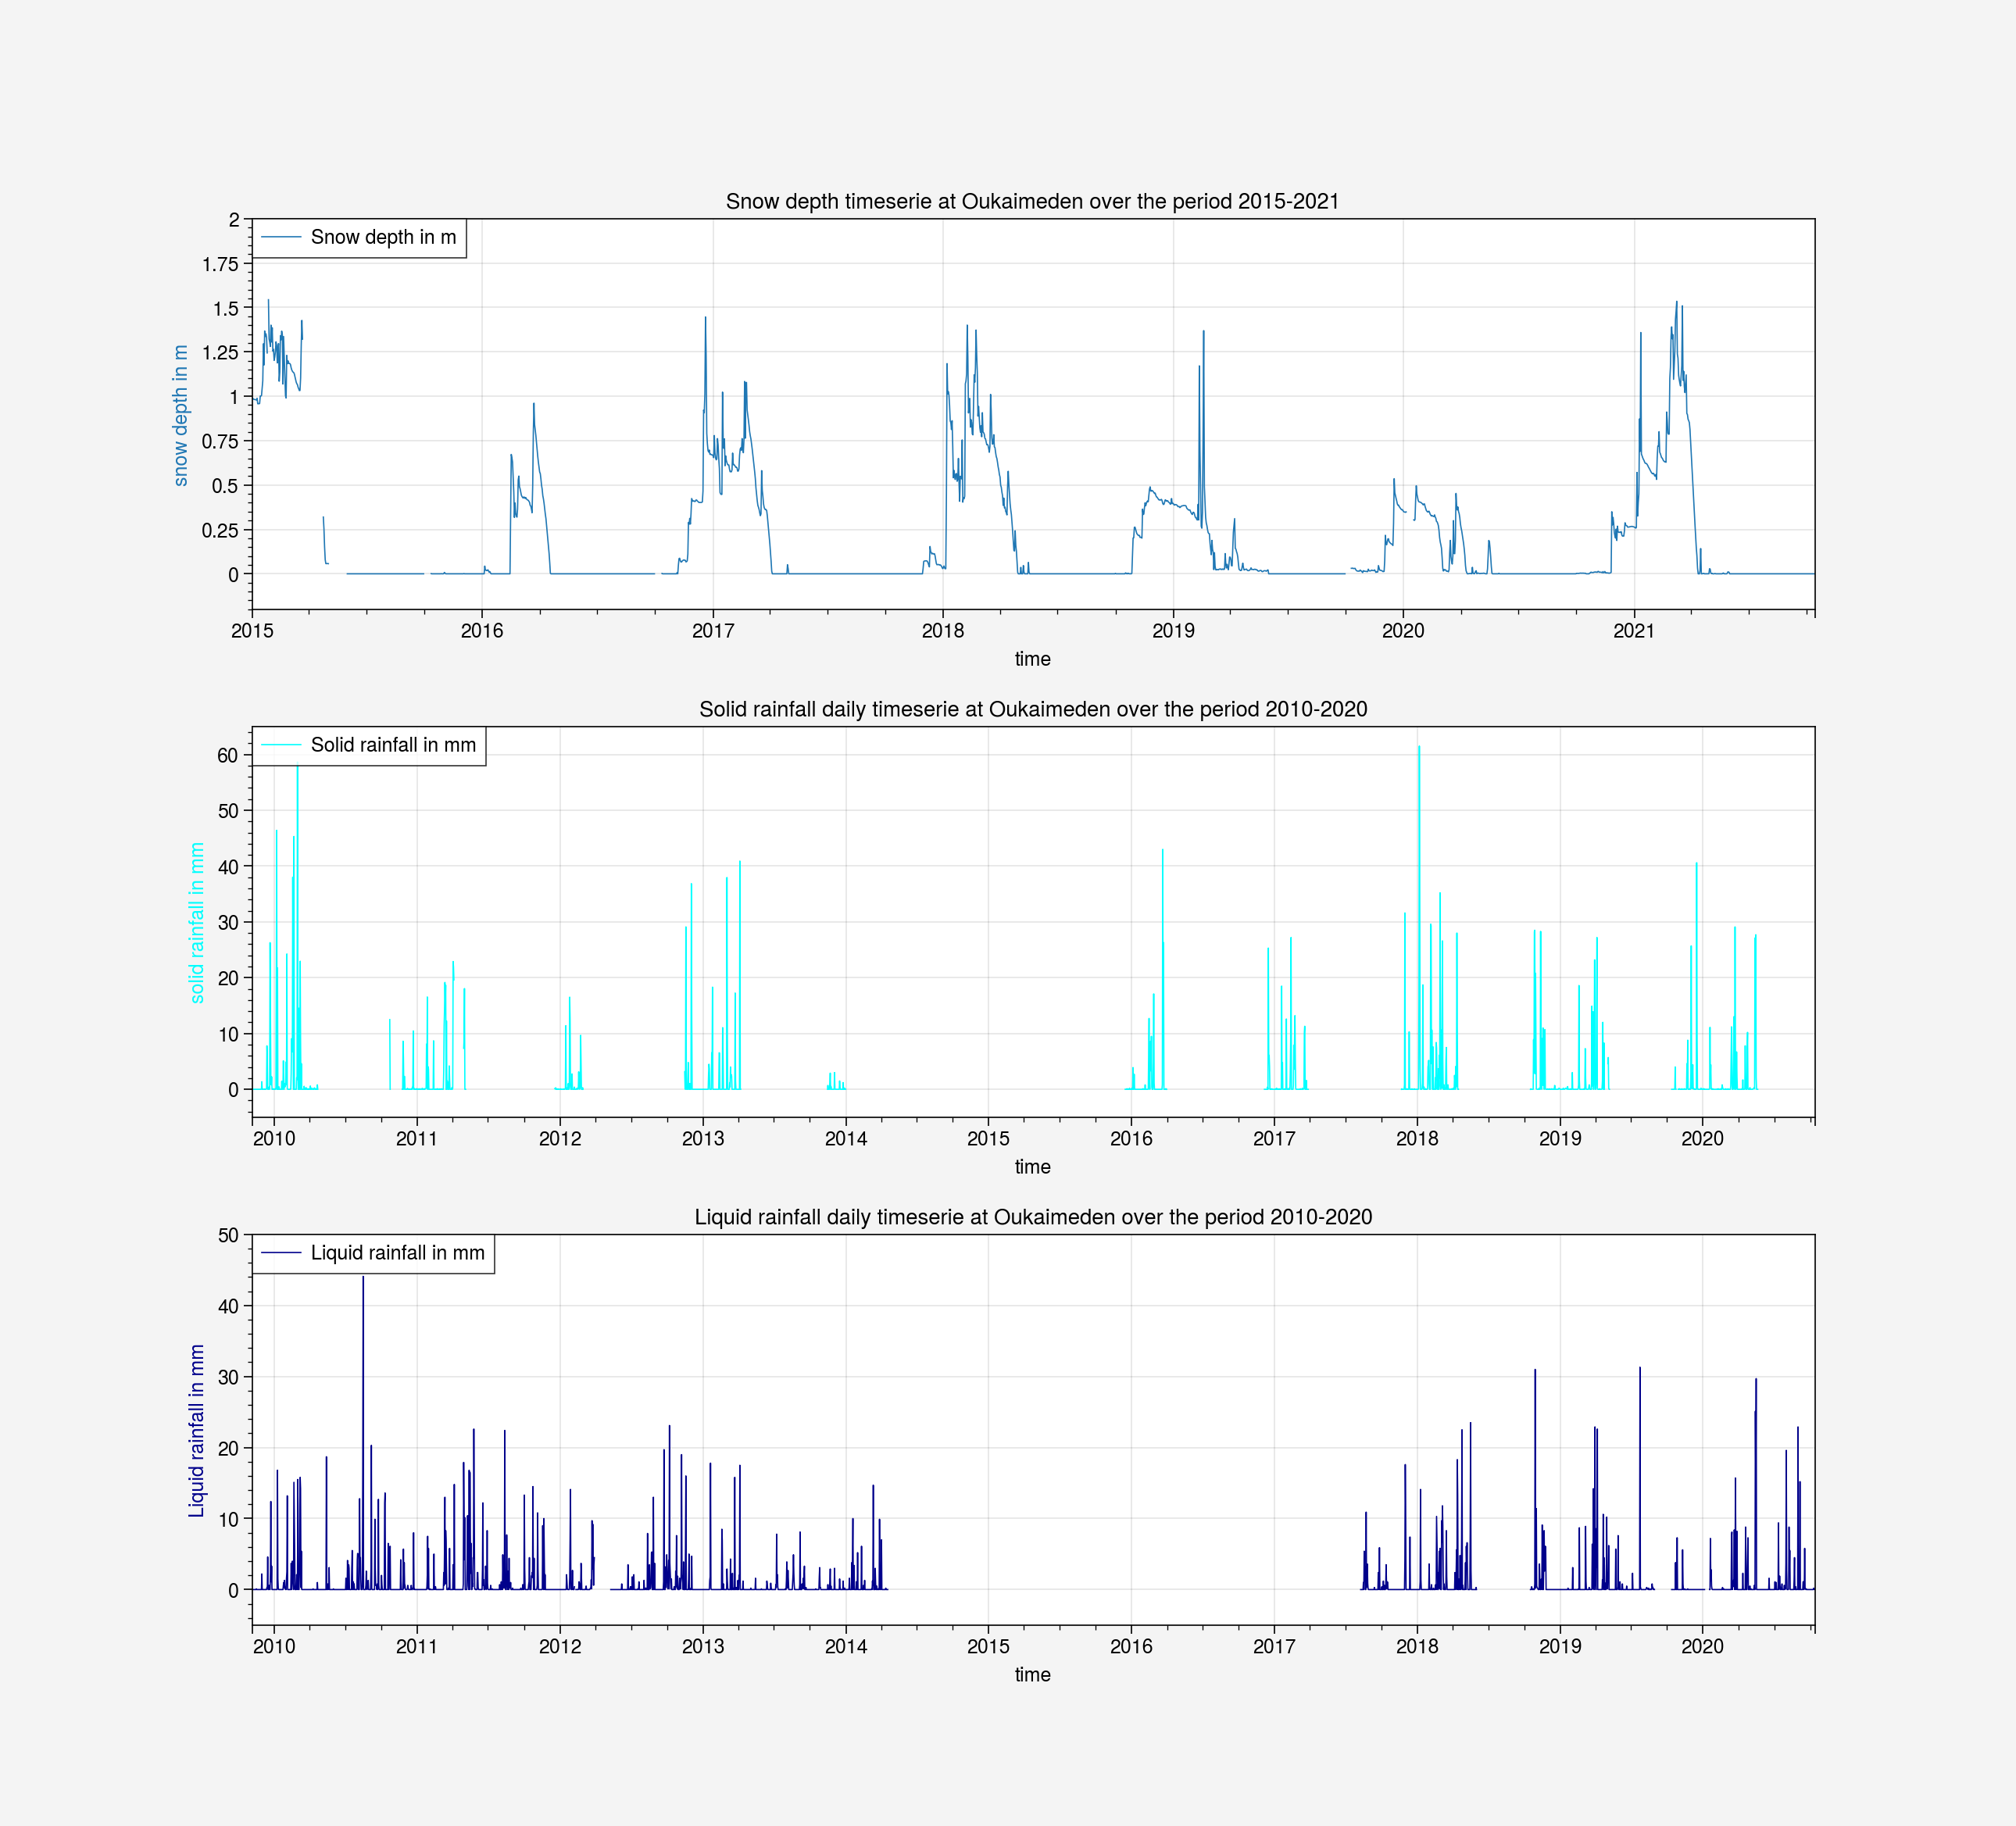

In [46]:
Noms=["Oukaimden (3230m)"]

fig, axs=plt.subplots(3,1) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=1,hspace=0.3)

# We fix the size of figure
set_size(10,9)

color1 = 'tab:blue'
color2 = '#00FFFF'
color3 = '#00008B'


ouk_SD['SD'].plot(ax=axs[0], ylim=[-0.2,2], color=color1, linewidth=0.6) 
axs[0].set_title("Snow depth timeserie at Oukaimeden over the period 2015-2021")
axs[0].set_xlabel("time") 
axs[0].legend(labels = ["Snow depth in m"], loc='upper left')
axs[0].set_ylabel("snow depth in m", color=color1) 
axs[0].set_ylim(-0.2,2)
# =======================================================================

ouk_P['N_J_Ouka_recons'].plot(ax=axs[1], ylim=[-5,65], color=color2, linewidth=0.6) 
axs[1].set_title("Solid rainfall daily timeserie at Oukaimeden over the period 2010-2020")
axs[1].set_xlabel("time") 
axs[1].legend(labels = ["Solid rainfall in mm"], loc='upper left')
axs[1].set_ylabel("solid rainfall in mm", color=color2) 
axs[1].set_ylim(-5,65)
# =======================================================================
      
ouk_P['P_J_Ouka'].plot(ax=axs[2], ylim=[-5,50], color=color3, linewidth=0.6) 
axs[2].set_title("Liquid rainfall daily timeserie at Oukaimeden over the period 2010-2020")
axs[2].set_xlabel("time") 
axs[2].legend(labels = ["Liquid rainfall in mm"], loc='upper left')
axs[2].set_ylabel("Liquid rainfall in mm", color=color3) 
axs[2].set_ylim(-5,50)


plt.savefig('/home/hchaabani/Desktop/Timeseries_visualizations_of_snow_depth_and_others_parameters_at_Oukaimeden_station/fig1.png')

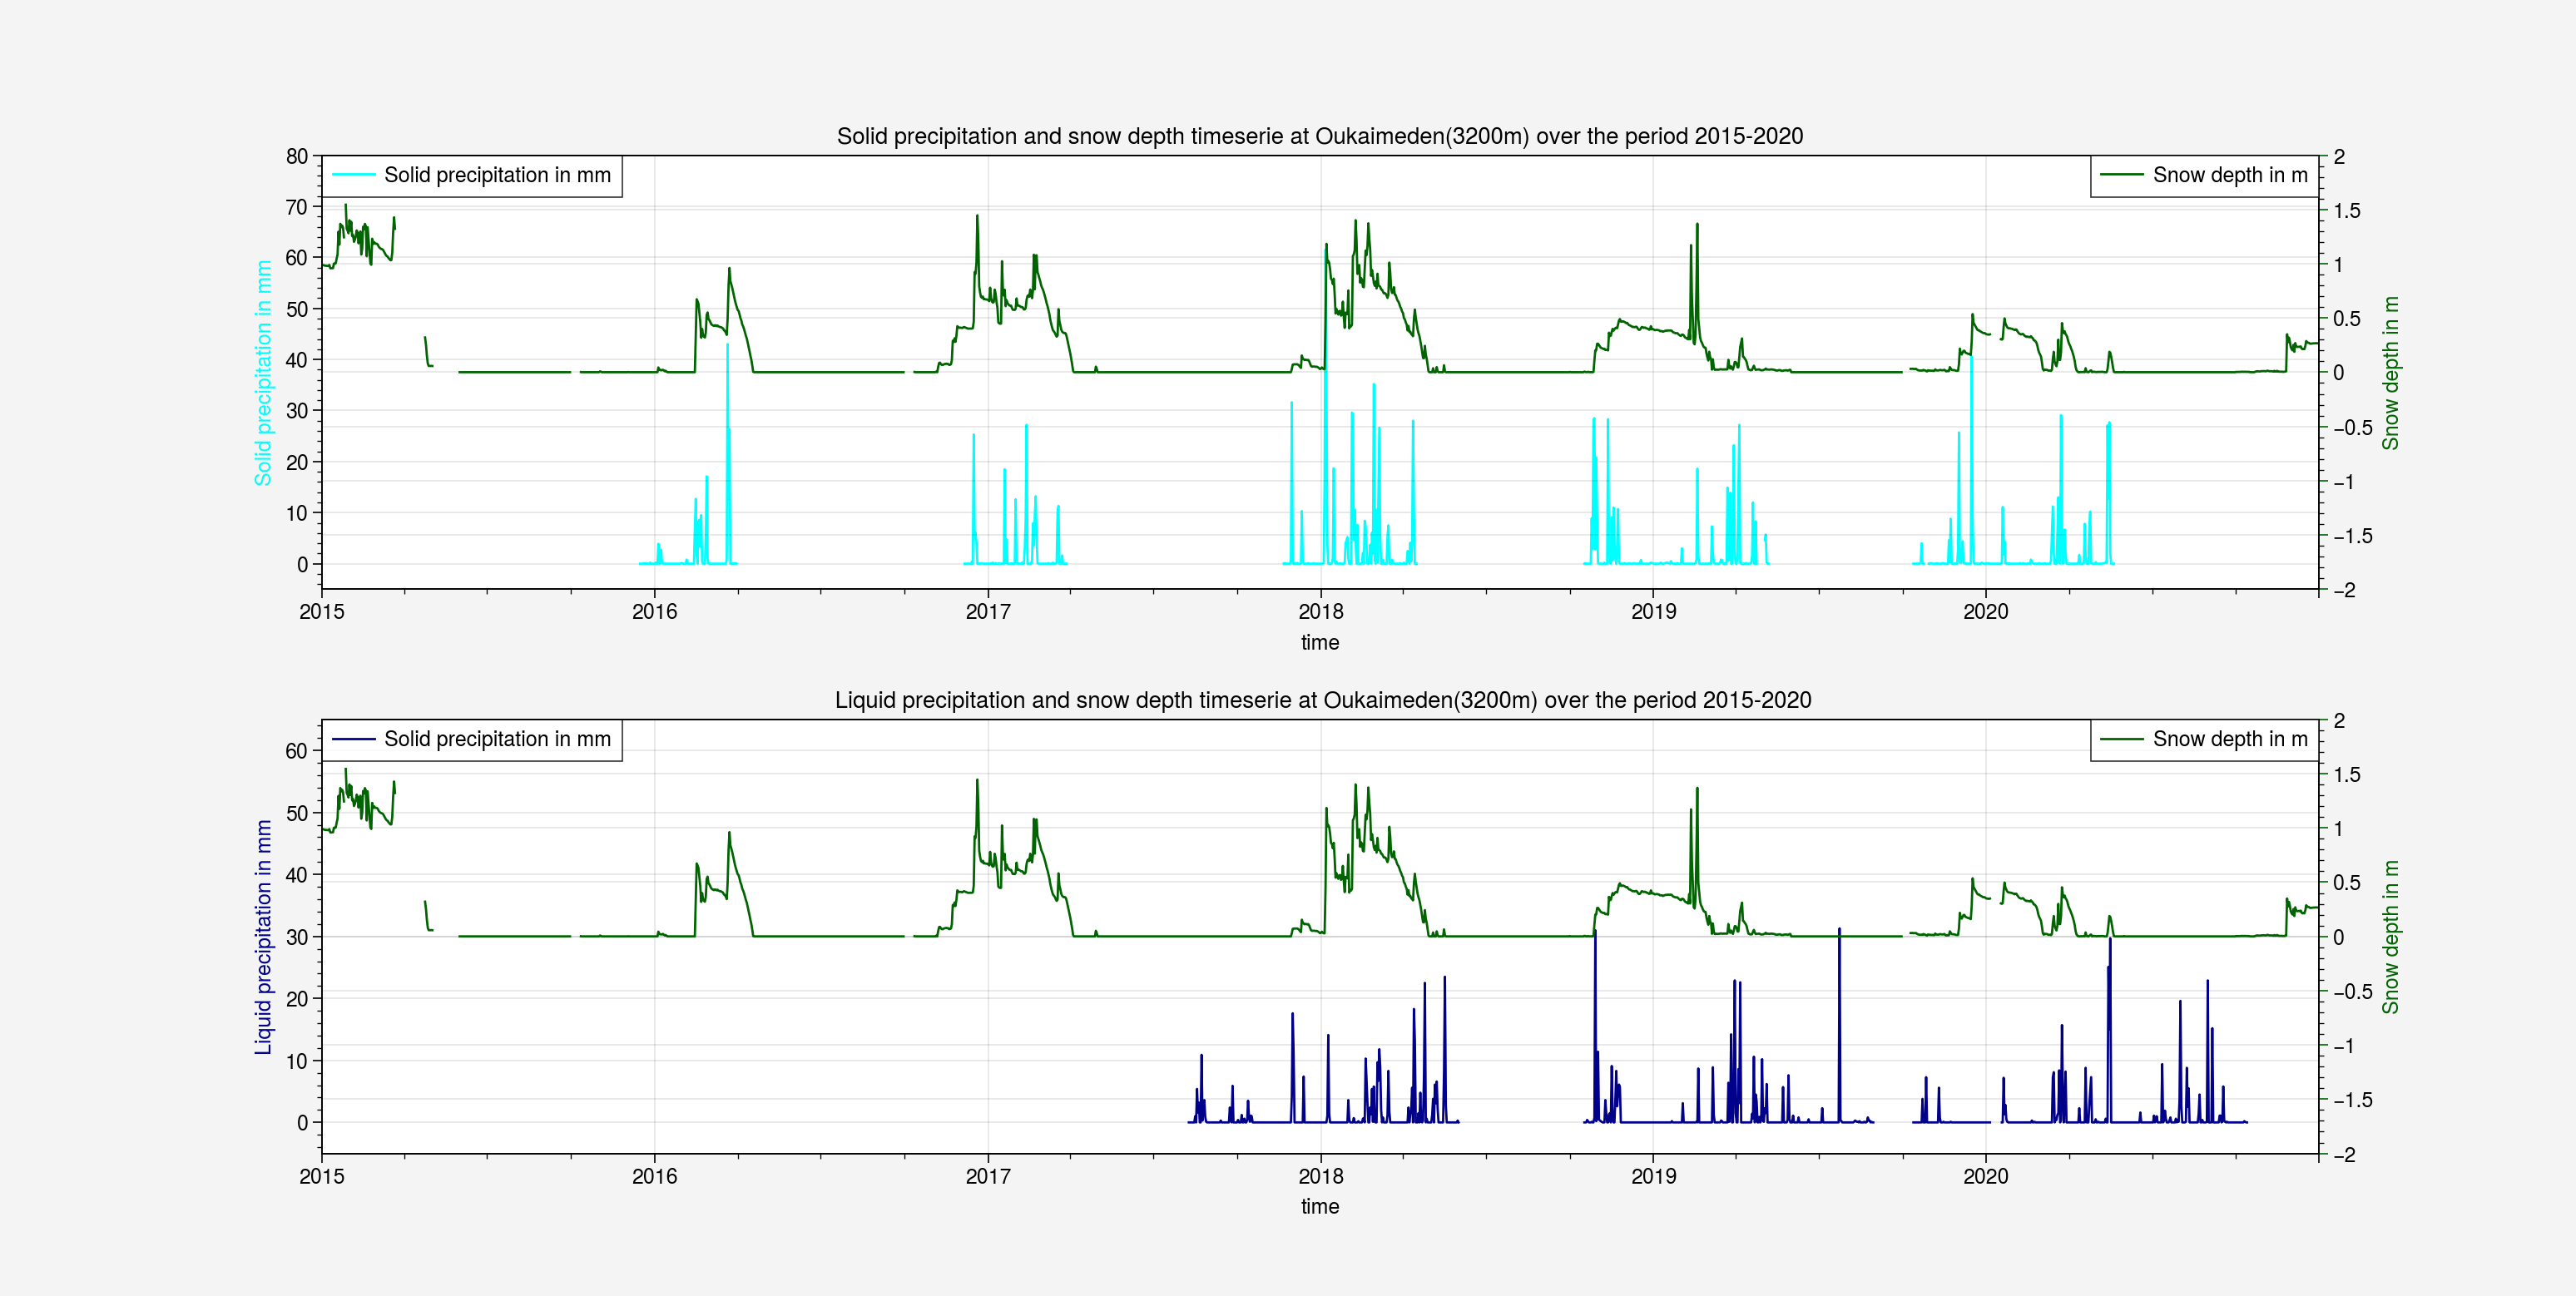

In [47]:
labels_legend = ['Solid precipitation in mm', 'Snow depth in m']

fig, axs=plt.subplots(2,1) 
# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=2,hspace=0.3)

# We fix the size of figure
set_size(12,6)
color1 = '#00FFFF'
color2 = '#00008B'
color3 = '#006400' 

ouk_P.loc['2015-01-01':'2020-12-31']['N_J_Ouka_recons'].plot(ax=axs[0], ylim=[-5,80], color=color1, linewidth=1)
axs[0].set_title("Solid precipitation and snow depth timeserie at Oukaimeden(3200m) over the period 2015-2020")
axs[0].set_xlabel("time")
axs[0].legend(labels = labels_legend, loc='upper left')
axs[0].set_ylabel("Solid precipitation in mm", color=color1) 
axs[0].set_ylim(-5,80)
    
ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis 
ax2.set_ylabel('Snow depth in m', color=color3)  # we already handled the x-label with ax1
ouk_SD.loc['2015-01-01':'2020-12-31']['SD'].plot(ax=ax2, ylim=[-2,2], color=color3, linewidth=1) 
ax2.tick_params(axis='y', color=color3)
ax2.legend(labels = ["Snow depth in m"], loc='upper right')
ax2.set_ylim(-2,2)

# ====================================================================================================
ouk_P.loc['2015-01-01':'2020-12-31']['P_J_Ouka'].plot(ax=axs[1], ylim=[-5,65], color=color2, linewidth=1)
axs[1].set_title(" Liquid precipitation and snow depth timeserie at Oukaimeden(3200m) over the period 2015-2020")
axs[1].set_xlabel("time")
axs[1].legend(labels = labels_legend, loc='upper left')
axs[1].set_ylabel("Liquid precipitation in mm", color=color2) 
axs[1].set_ylim(-5,65)
    
ax2 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis 
ax2.set_ylabel('Snow depth in m', color=color3)  # we already handled the x-label with ax1
ouk_SD.loc['2015-01-01':'2020-12-31']['SD'].plot(ax=ax2, ylim=[-2,2], color=color3, linewidth=1) 
ax2.tick_params(axis='y', color=color3)
ax2.legend(labels = ["Snow depth in m"], loc='upper right')
ax2.set_ylim(-2,2)

plt.savefig('/home/hchaabani/Desktop/Timeseries_visualizations_of_snow_depth_and_others_parameters_at_Oukaimeden_station/fig2.png')

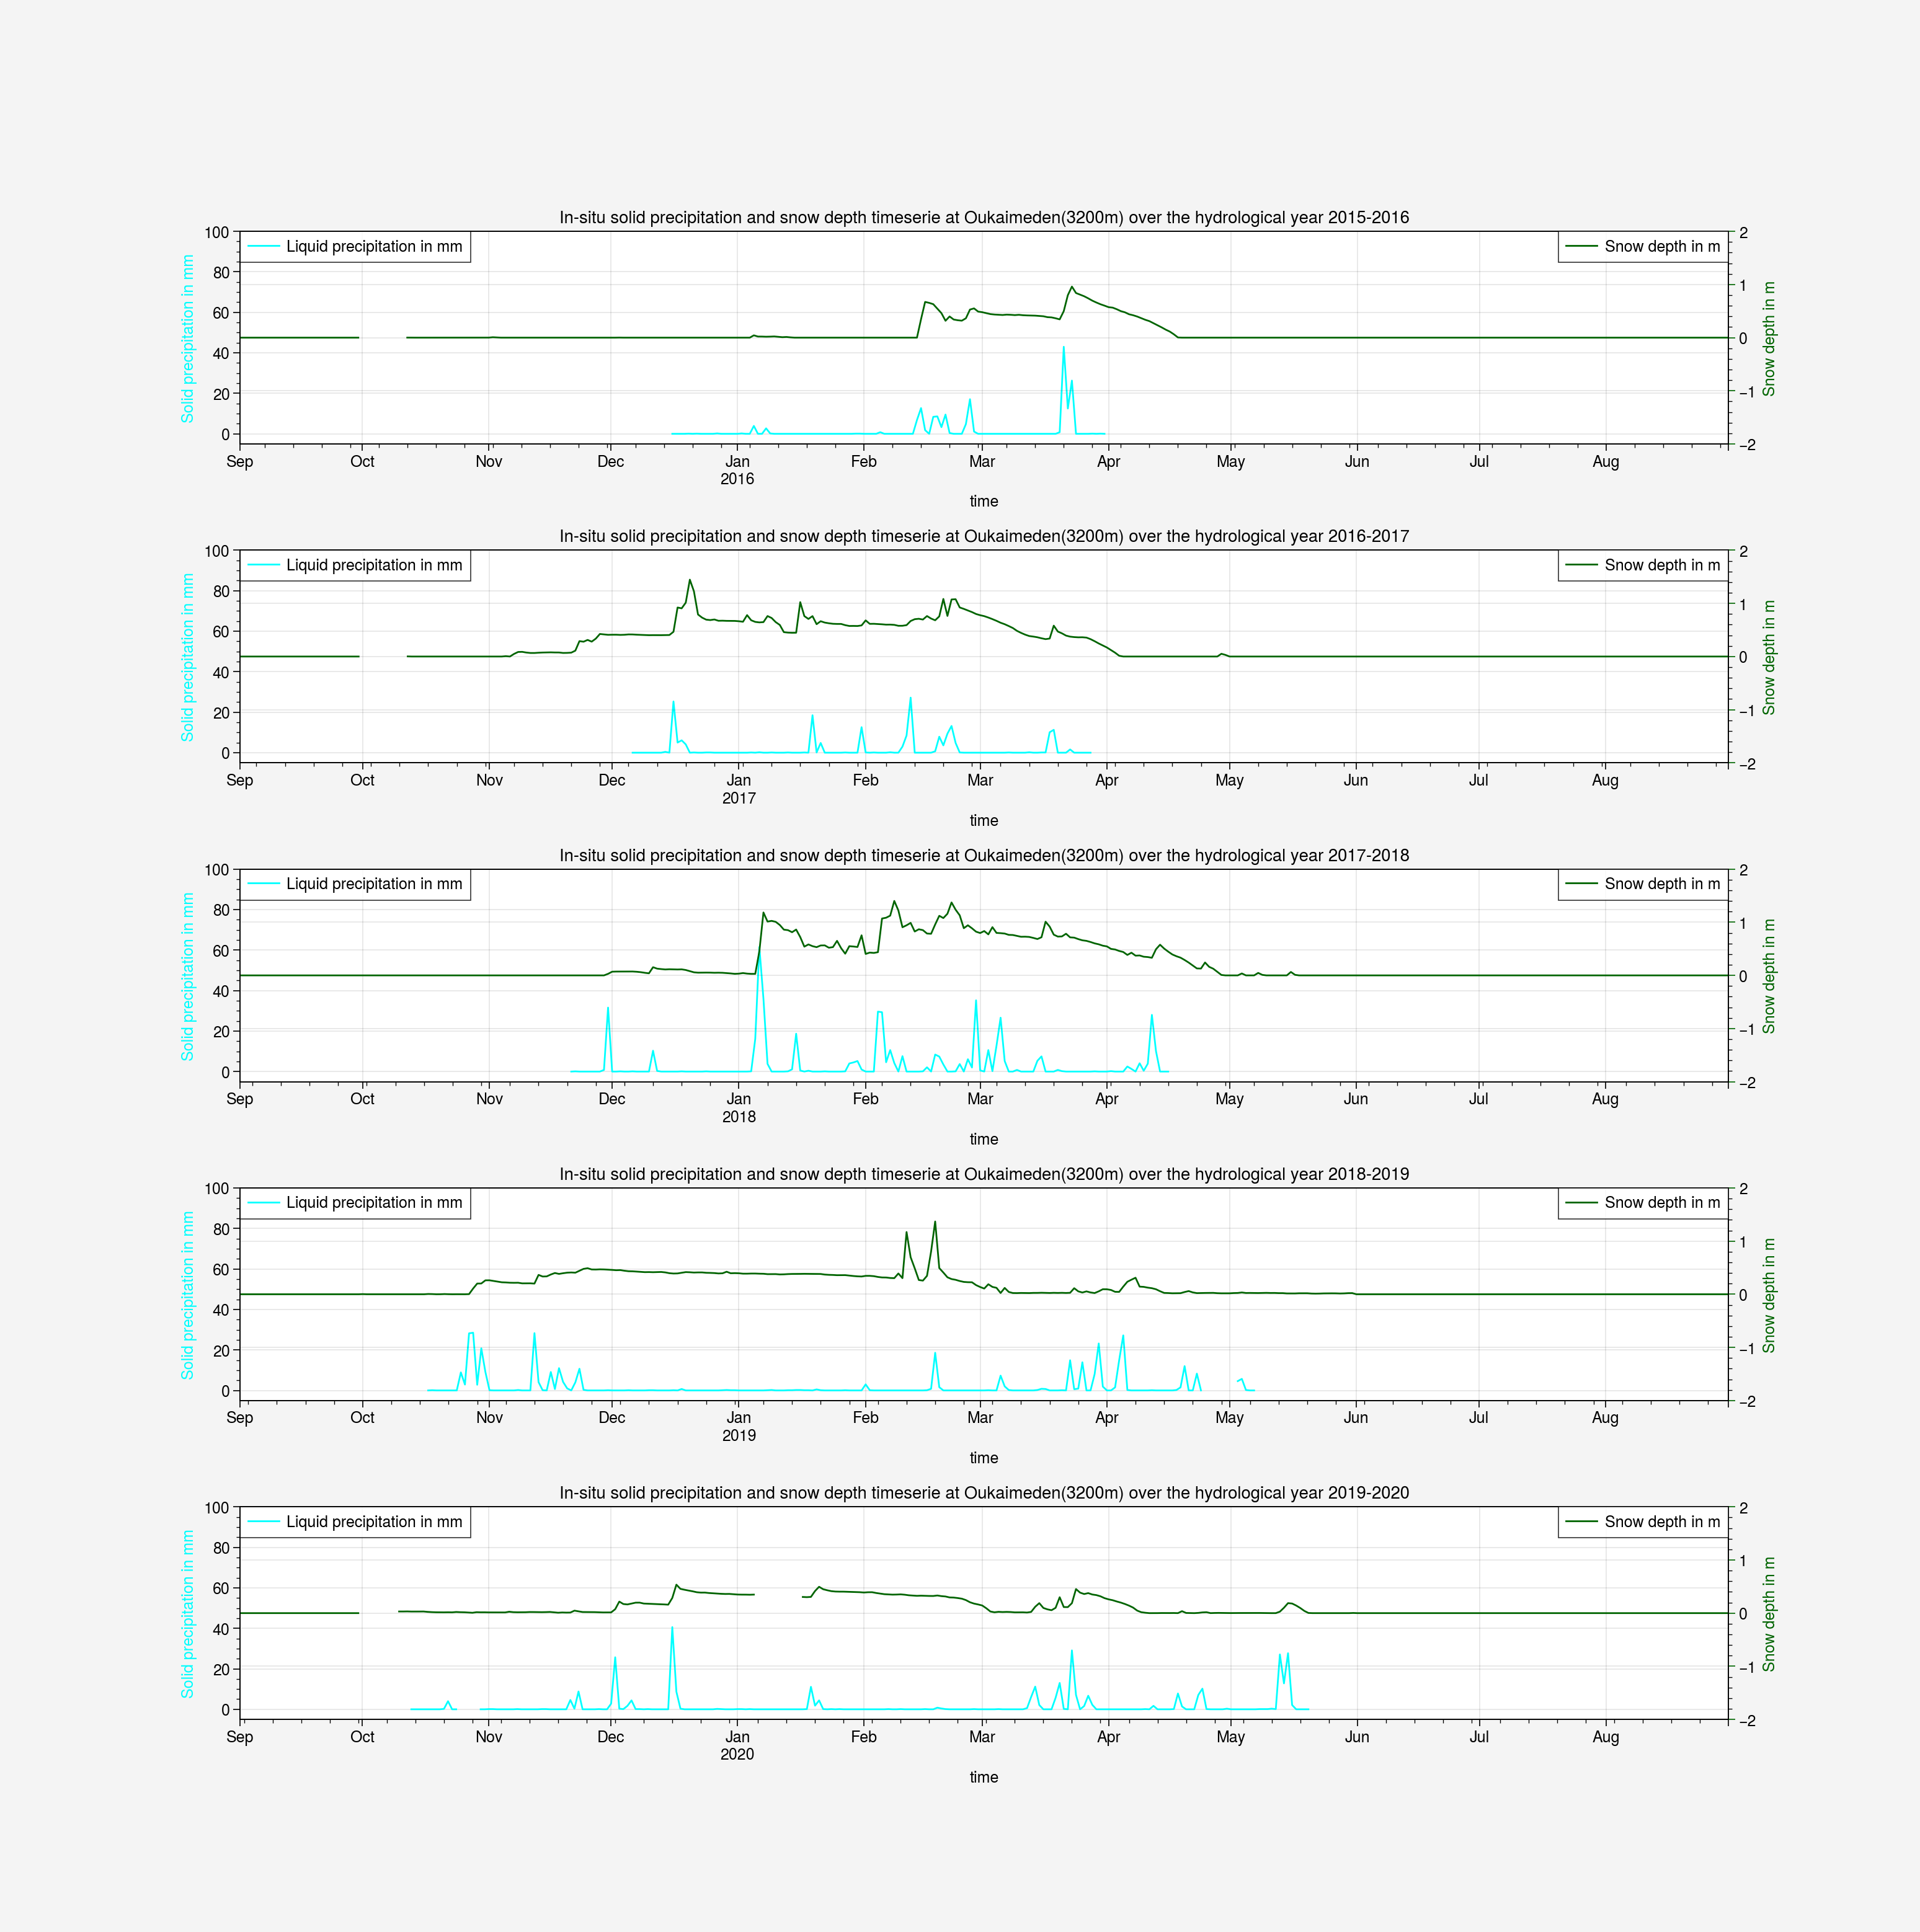

In [48]:
labels_years = ["2015-2016","2016-2017","2017-2018","2018-2019","2019-2020"]
labels_legend = ['Liquid precipitation in mm', 'Snow depth in m']

fig, axs=plt.subplots(5,1) 
# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=2,hspace=0.5)

# We fix the size of figure
set_size(12,12)
color1 = '#00FFFF'
color2 = '#00008B'
color3 = '#006400' 

year=2015
for i in range(5):
    ouk_P.loc[str(year)+'-09-01':str(year+1)+'-08-31']['N_J_Ouka_recons'].plot(ax=axs[i], ylim=[-5,100], color=color1, linewidth=1)
    axs[i].set_title("In-situ solid precipitation and snow depth timeserie at Oukaimeden(3200m) over the hydrological year "+labels_years[i])
    axs[i].set_xlabel("time")
    axs[i].legend(labels = labels_legend, loc='upper left')
    axs[i].set_ylabel("Solid precipitation in mm", color=color1) 
    axs[i].set_ylim(-5,100)
    
    ax2 = axs[i].twinx()  # instantiate a second axes that shares the same x-axis 
    ax2.set_ylabel('Snow depth in m', color=color3)  # we already handled the x-label with ax1
    ouk_SD.loc[str(year)+'-09-01':str(year+1)+'-08-31']['SD'].plot(ax=ax2, ylim=[-2,2], color=color3, linewidth=1) 
    ax2.tick_params(axis='y', color=color3)
    ax2.legend(labels = ["Snow depth in m"], loc='upper right')
    year = year + 1
    

plt.savefig('/home/hchaabani/Desktop/Timeseries_visualizations_of_snow_depth_and_others_parameters_at_Oukaimeden_station/fig2.png')

## Yearly value and monthly average of the number of days with snow

In [49]:
aux = ouk_SD

In [50]:
aux = aux.set_index('year')

/home/hchaabani/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [51]:
aux

,month,day,SD
year,,,
2015,1,1,0.990833
2015,1,2,0.987812
2015,1,3,0.985438
2015,1,4,0.98225
2015,1,5,0.981625
...,...,...,...
2021,10,10,0
2021,10,11,0
2021,10,12,0


In [52]:
NDS=aux['SD'].where(aux['SD'] > 0).groupby('year').count()
NDSWE=aux['SD'].where(aux['SD'] > 0).groupby('year').count() * 365 / (aux['SD'].where(aux['SD'] > 0).groupby('year').count() + aux['SD'].where(aux['SD'] == 0).groupby('year').count())


In [53]:
NDS

year
2015     97
2016    131
2017    128
2018    197
2019    234
2020    211
2021    123
Name: SD, dtype: int64

In [54]:
data = pd.concat([NDSWE, NDS], axis=1)

"\n-> fontsize can take the following value : # xx-small', 'x-small',\n'small', 'medium', 'large', 'x-large', 'xx-large\n\n"

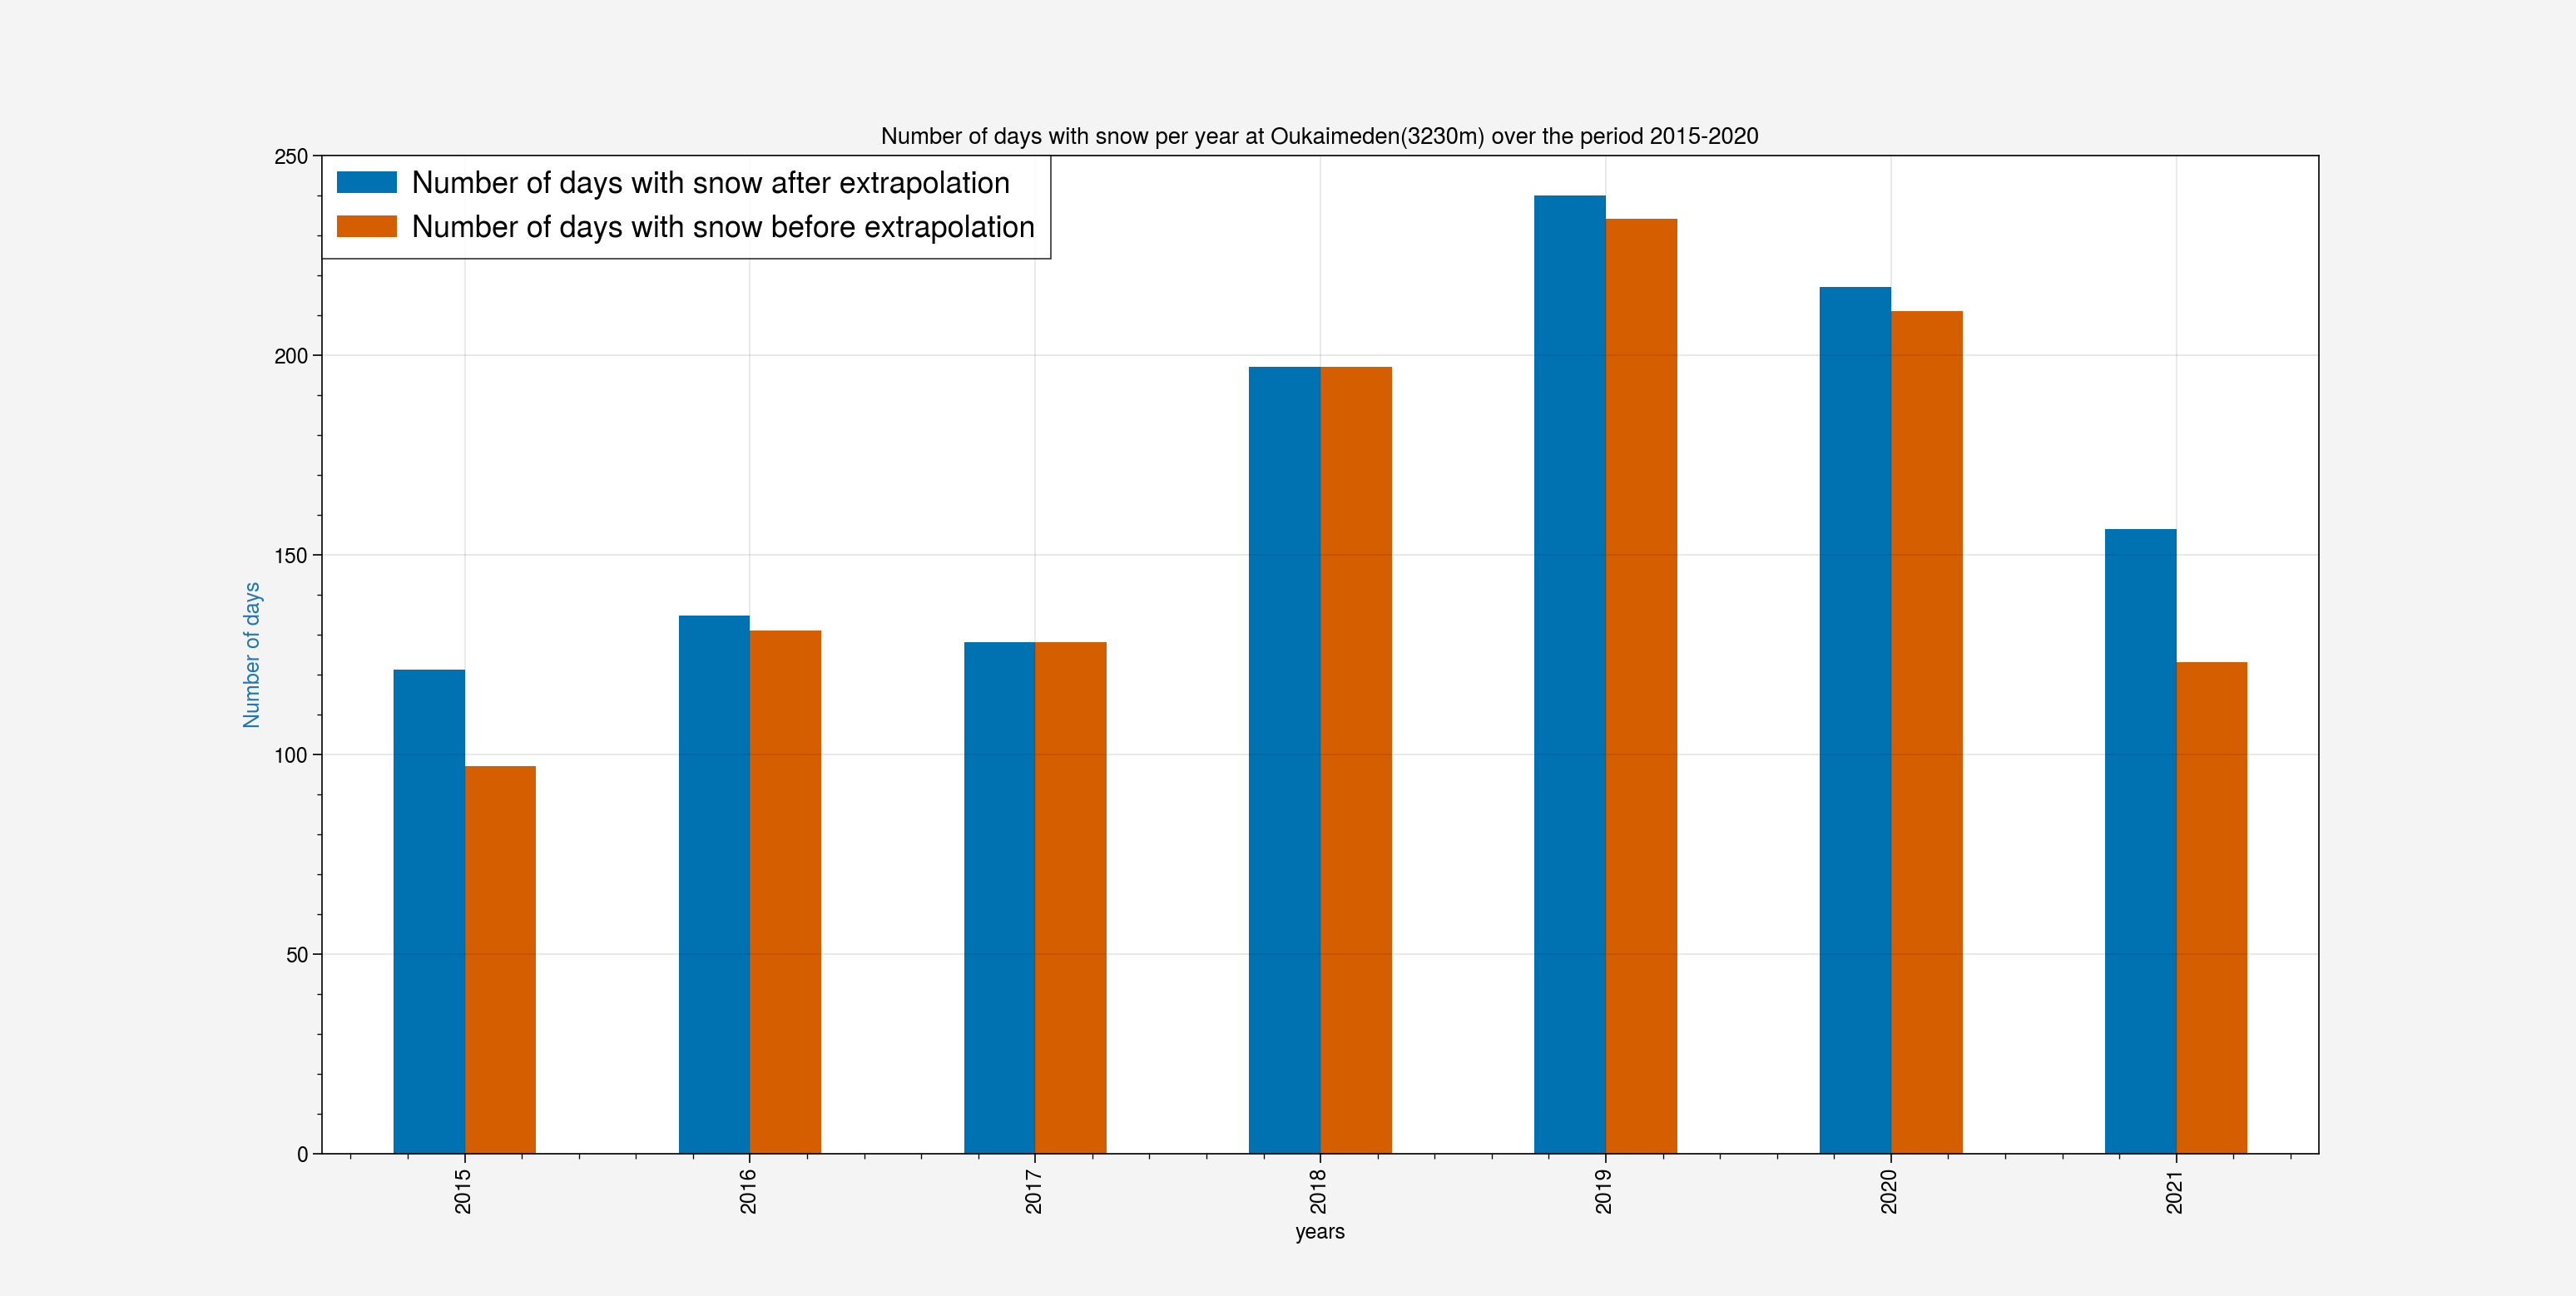

In [56]:
fig, ax=plt.subplots() 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.1,hspace=0.65)

# We fix the size of figure
set_size(12,6)     

, female, width=0.4
color1 = 'tab:blue'
color2 = 'tab:brown'
data.plot.bar(ax=ax)
ax.set_title("Number of days with snow per year at Oukaimeden(3230m) over the period 2015-2020") 
ax.set_xlabel("years") 
ax.legend(labels = ["Number of days with snow after extrapolation", "Number of days with snow before extrapolation"], loc='upper left', fontsize='x-large')
ax.set_ylabel("Number of days", color=color1) 
ax.set_ylim(0,250)

plt.savefig('/home/hchaabani/Desktop/Timeseries_visualizations_of_snow_depth_and_others_parameters_at_Oukaimeden_station/fig4.png')




# ============= Notes =================
"""
-> fontsize can take the following value : # xx-small', 'x-small',
'small', 'medium', 'large', 'x-large', 'xx-large

"""

In [57]:
aux = ouk_SD[['year', 'month' , 'SD']]

In [58]:
aux = aux.set_index('month')

/home/hchaabani/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [59]:
NDS=aux['SD'].where(aux['SD'] > 0).groupby('month').count()/7
NDSWE=aux['SD'].where(aux['SD'] > 0).groupby('month').count() * 212.8 / (aux['SD'].where(aux['SD'] > 0).groupby('month').count() + aux['SD'].where(aux['SD'] == 0).groupby('month').count())/7


In [60]:
NDSWE

month
1     27.285854
2     28.250505
3     30.400000
4     22.109091
5     11.157447
6      0.000000
7      0.000000
8      0.000000
9      0.000000
10    11.692308
11    20.097778
12    25.496774
Name: SD, dtype: float64

In [61]:
NDS = NDS.astype(int)

In [62]:
NDSWE = NDSWE.astype(int)

In [63]:
data = pd.concat([NDSWE, NDS], axis=1)

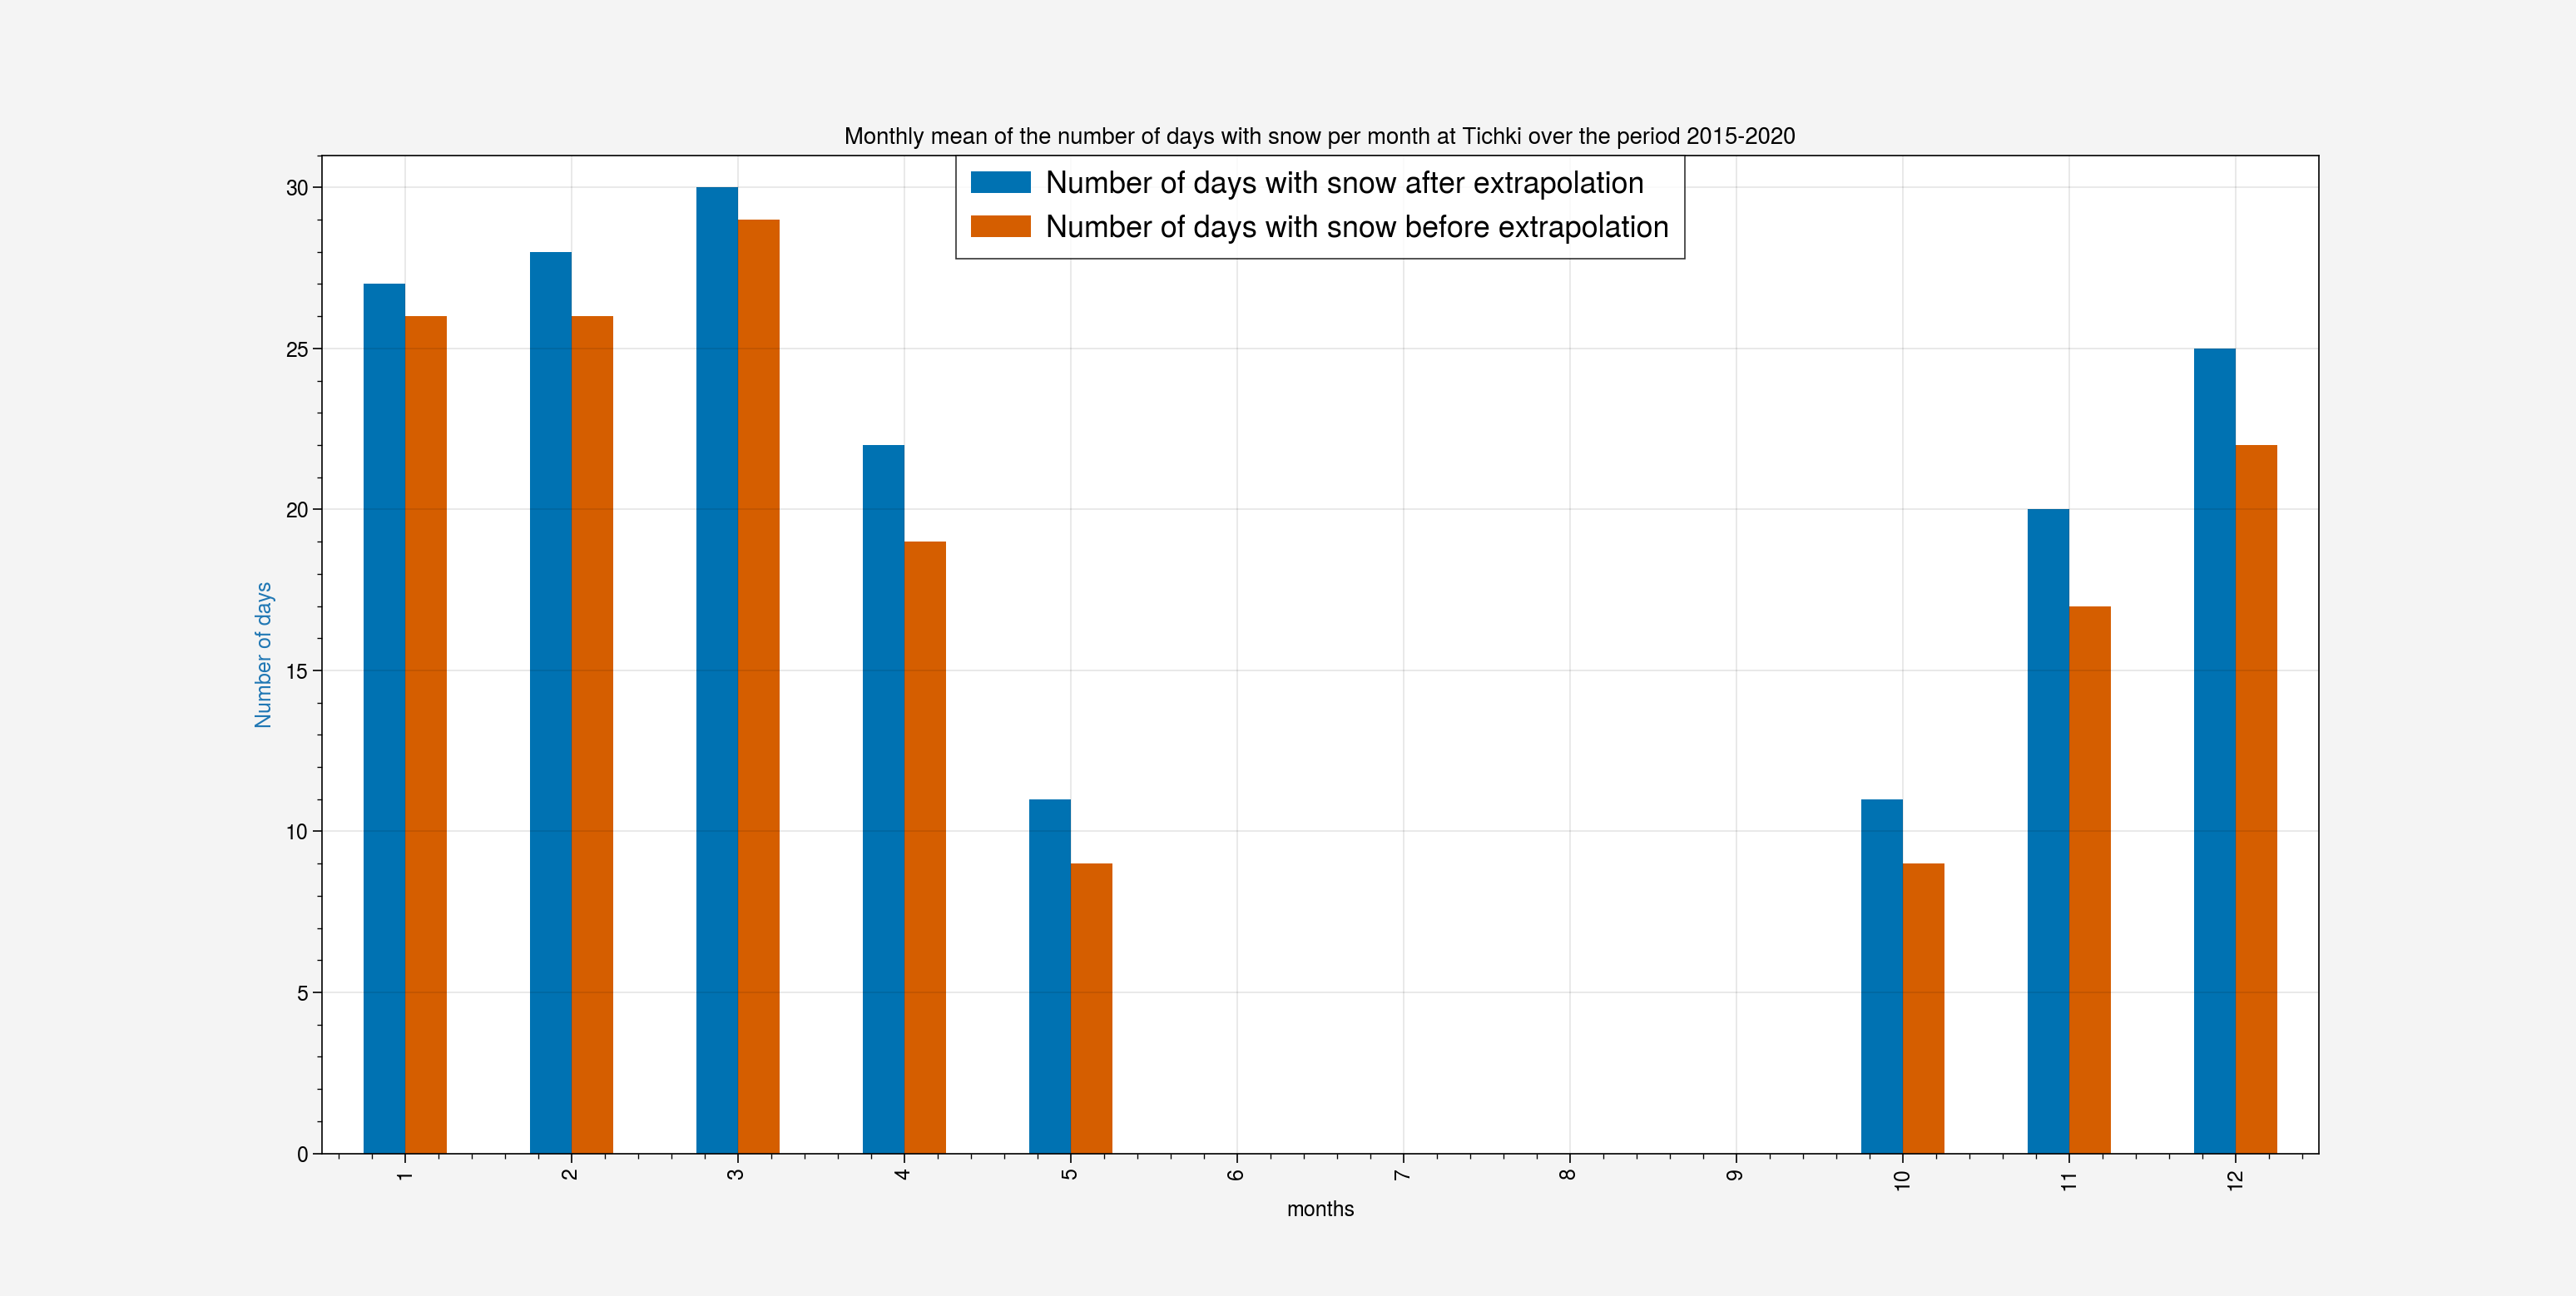

In [64]:
Noms=["Oukaimeden (3260m)"]
fig, ax=plt.subplots() 
# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.1,hspace=0.65)

# We fix the size of figure
set_size(12,6)     

, female, width=0.4
color1 = 'tab:blue'
color2 = 'tab:brown'
data.plot.bar(ax=ax)
ax.set_title("Monthly mean of the number of days with snow per month at Tichki over the period 2015-2020")
ax.set_xlabel("months") 
ax.legend(labels = ["Number of days with snow after extrapolation", "Number of days with snow before extrapolation"], loc='upper center', fontsize='x-large')
ax.set_ylabel("Number of days", color=color1) 
ax.set_ylim(0,31)

plt.savefig('/home/hchaabani/Desktop/Timeseries_visualizations_of_snow_depth_and_others_parameters_at_Oukaimeden_station/fig5.png')
